# Part C:

# 1 Data Loading

In [2]:
import os
import shutil

# Define the directories
train_dir = 'pathologyData/pathologyData/train'
test_dir = 'pathologyData/pathologyData/test'

# Output directories for filtered data
train_output_dir = 'pathologyData/pathologyData_filtered/train'
masked_train_output_dir = 'pathologyData/pathologyData_filtered/masked_train'
test_non_masked_output_dir = 'pathologyData/pathologyData_filtered/test_non_masked'

# Create output directories if they don't exist
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(masked_train_output_dir, exist_ok=True)
os.makedirs(test_non_masked_output_dir, exist_ok=True)

# Function to filter and copy masked and non-masked test files
def separate_test_files(test_dir, test_non_masked_output_dir):
    masked_files = [f for f in os.listdir(test_dir) if f.endswith('.out.png')]
    non_masked_files = [f for f in os.listdir(test_dir) if f.endswith('.tif') and not f.endswith('.out.png')]

    for file in non_masked_files:
        src = os.path.join(test_dir, file)
        dst = os.path.join(test_non_masked_output_dir, file)
        shutil.copy(src, dst)

    print(f'Copied {len(non_masked_files)} non-masked test files')

# Separate non-masked files in the test folder
separate_test_files(test_dir, test_non_masked_output_dir)

# Function to separate and copy training files
def separate_and_copy_train_files(train_dir, train_output_dir, masked_train_output_dir):
    # List all files
    original_files = sorted([f for f in os.listdir(train_dir) if f.endswith('.tif') and not f.endswith('.out.png')])
    mask_files = sorted([f for f in os.listdir(train_dir) if f.endswith('.out.png')])

    # Copy normal images to train output directory
    for file in original_files:
        src = os.path.join(train_dir, file)
        dst = os.path.join(train_output_dir, file)
        shutil.copy(src, dst)
    
    # Copy masked images to masked train output directory
    for file in mask_files:
        src = os.path.join(train_dir, file)
        dst = os.path.join(masked_train_output_dir, file)
        shutil.copy(src, dst)

    print(f'Copied {len(original_files)} normal training files to {train_output_dir}')
    print(f'Copied {len(mask_files)} masked training files to {masked_train_output_dir}')

# Separate and copy train files
separate_and_copy_train_files(train_dir, train_output_dir, masked_train_output_dir)

print('File separation and copying completed.')


Copied 24 non-masked test files
Copied 60 normal training files to pathologyData/pathologyData_filtered/train
Copied 60 masked training files to pathologyData/pathologyData_filtered/masked_train
File separation and copying completed.


In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
class PathologyDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")

        if self.mask_dir is not None:
            mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.tif', '.out.png'))
            mask = Image.open(mask_path).convert("L")
        else:
            mask = Image.new("L", image.size)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_image_dir = 'pathologyData/pathologyData_filtered/train'
masked_train_dir = 'pathologyData/pathologyData_filtered/masked_train'
test_image_dir = 'pathologyData/pathologyData_filtered/test_non_masked'

train_dataset = PathologyDataset(train_image_dir, masked_train_dir, transform=transform)
test_dataset = PathologyDataset(test_image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


C:\Users\Admin\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 2 Model Defining (Unet With ResNet Backbone For Segmentation)

In [29]:
import torch.nn as nn
import torchvision.models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out


# 3 Model Training and Metrics Evaluation

In [30]:
import torch.optim as optim
from collections import defaultdict
import torch.nn.functional as F
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(1)
model = model.to(device)

# Define the optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Dice loss function
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    
    return 1 - dice.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in (train_loader if phase == 'train' else test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

# Training the model
checkpoint_path = "checkpoint.pth"
model = train_model(model, optimizer, scheduler, num_epochs=25)


device cpu
Epoch 0/24
----------
train: bce: 0.960207, dice: 0.779454, loss: 0.869830
LR 0.001
val: bce: 0.290146, dice: 0.999939, loss: 0.645042
saving best model to checkpoint.pth
2m 21s
Epoch 1/24
----------
train: bce: 0.446239, dice: 0.788885, loss: 0.617562
LR 0.001
val: bce: 0.243875, dice: 0.999927, loss: 0.621901
saving best model to checkpoint.pth
2m 35s
Epoch 2/24
----------
train: bce: 0.442326, dice: 0.722962, loss: 0.582644
LR 0.001
val: bce: 0.189476, dice: 0.999900, loss: 0.594688
saving best model to checkpoint.pth
2m 35s
Epoch 3/24
----------
train: bce: 0.360895, dice: 0.629191, loss: 0.495043
LR 0.001
val: bce: 0.194996, dice: 0.999818, loss: 0.597407
2m 33s
Epoch 4/24
----------
train: bce: 0.341504, dice: 0.512239, loss: 0.426872
LR 0.001
val: bce: 0.461035, dice: 0.999909, loss: 0.730472
2m 33s
Epoch 5/24
----------
train: bce: 0.312616, dice: 0.470826, loss: 0.391721
LR 0.001
val: bce: 0.217313, dice: 0.999789, loss: 0.608551
2m 33s
Epoch 6/24
----------
train: 

In [9]:
from PIL import Image

# 4 Model Evaluation And Test Plot

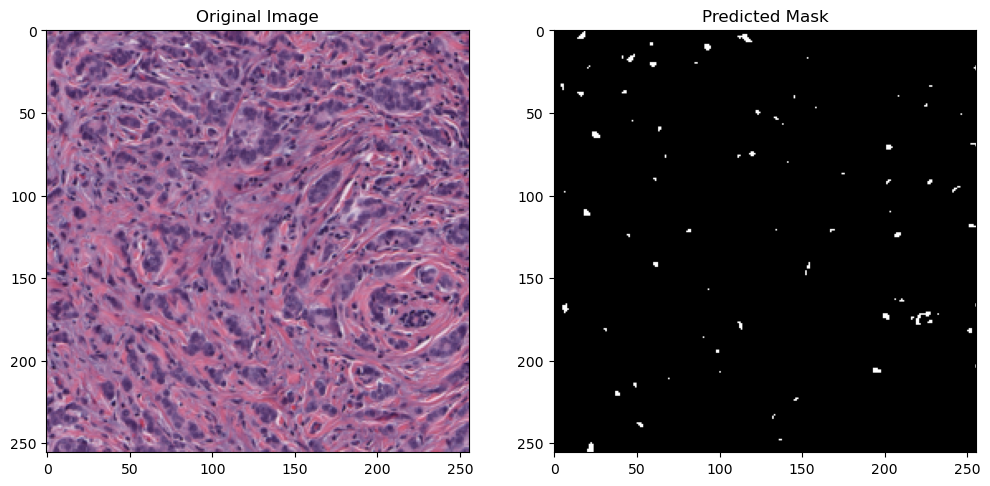

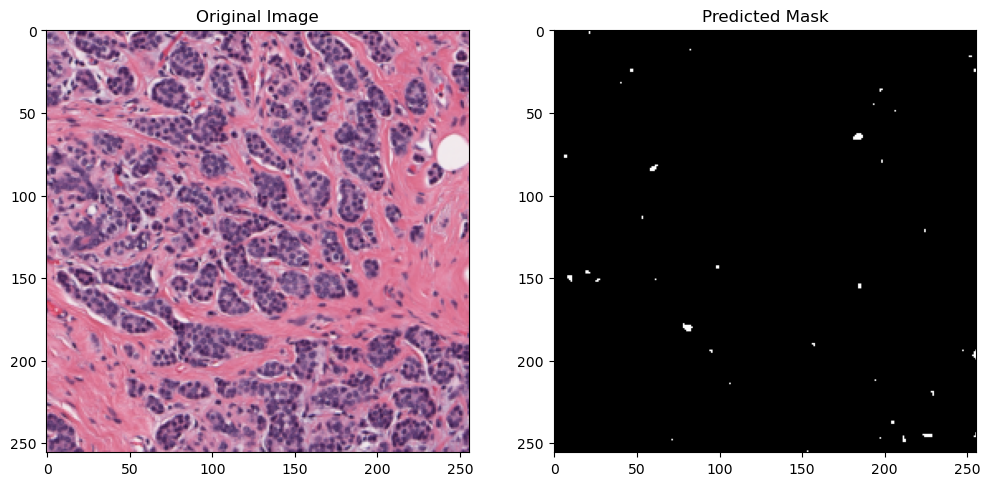

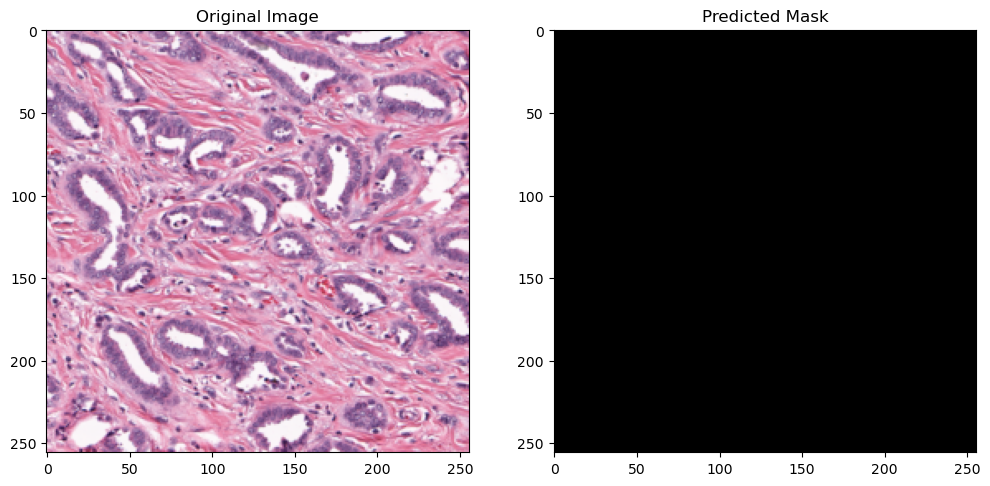

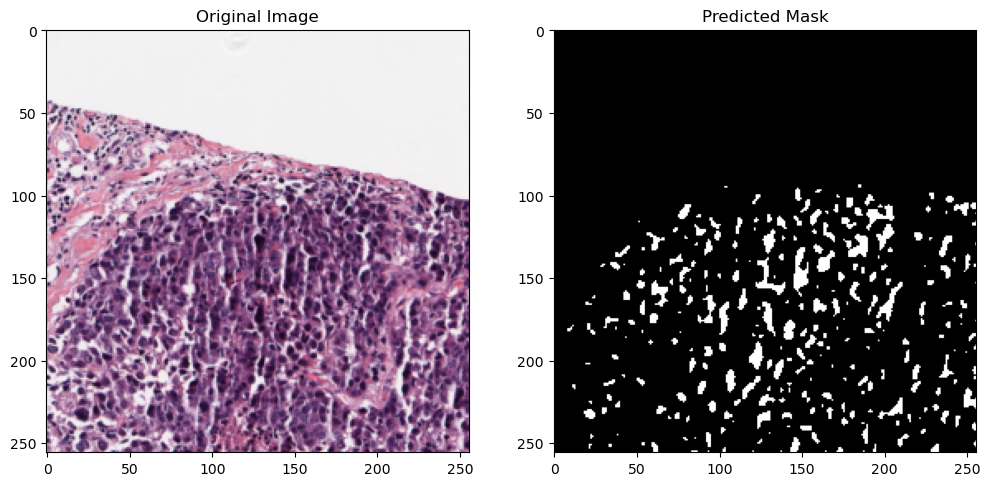

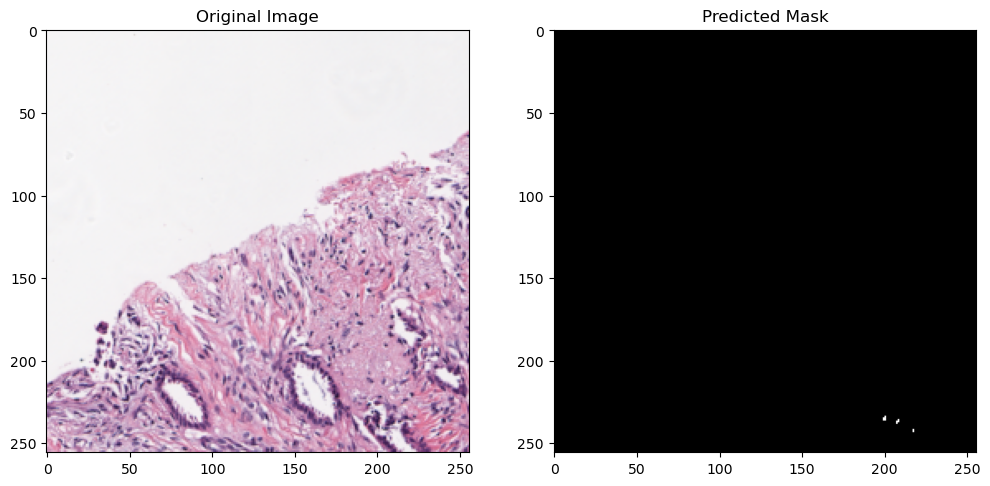

In [31]:
import matplotlib.pyplot as plt

# Predict on test data
model.eval()
predicted_masks = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        predicted_masks.extend(preds)

predicted_masks = (np.array(predicted_masks) > 0.5).astype(np.uint8)

# Display some predictions
def display_sample_images(images, predicted_masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(images[i].permute(1, 2, 0))

        plt.subplot(1, 2, 2)
        plt.title('Predicted Mask')
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')

        plt.show()

# Get sample images
sample_images, _ = next(iter(test_loader))
sample_images = sample_images.cpu()

# Display sample predictions
display_sample_images(sample_images, predicted_masks, num_samples=5)


Inference:

•	Defined the model metrics and trained the model over 24 epochs. The training loss was loss, i.e., 33%, but the test loss was higher. Which shows model overfitting. 

In [13]:
pip install segmentation_models_pytorch

  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/58.8 kB ? eta -:--:--
     ---------------------------------------- 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/68.5 kB ? eta -:--:--
     ---------------------------------------- 68.5/68.5 kB 3.6 MB/s eta 0:00:00
  Obtaining dependency information for munch from htt

# Traing Using predefined Unet with resnet backbone

In [14]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [20]:
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)  # Assuming binary segmentation

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define accuracy metric
def accuracy(preds, labels):
    preds = torch.round(torch.sigmoid(preds))
    correct = (preds == labels).float()
    acc = correct.sum() / correct.numel()
    return acc

# Model Training And Evaluation

In [21]:
# Training loop
num_epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += accuracy(outputs, masks).item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            val_acc += accuracy(outputs, masks).item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_acc / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Train Acc: {train_acc/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}, Val Acc: {val_acc/len(test_loader)}')



Epoch 1/25, Train Loss: 0.7020478323101997, Train Acc: 0.37110018730163574, Val Loss: 1.3790759642918904, Val Acc: 0.40122413635253906
Epoch 2/25, Train Loss: 0.48780664801597595, Train Acc: 0.540809154510498, Val Loss: 0.3376605113347371, Val Acc: 0.8736337025960287
Epoch 3/25, Train Loss: 0.3891826309263706, Train Acc: 0.5585296154022217, Val Loss: 0.5054418941338857, Val Acc: 0.7729148864746094
Epoch 4/25, Train Loss: 0.33548209071159363, Train Acc: 0.5635888576507568, Val Loss: 0.20696625610192618, Val Acc: 0.9281667073567709
Epoch 5/25, Train Loss: 0.30984093248844147, Train Acc: 0.5582079887390137, Val Loss: 0.2833029329776764, Val Acc: 0.8719088236490885
Epoch 6/25, Train Loss: 0.2810821048915386, Train Acc: 0.5611205101013184, Val Loss: 0.2956506013870239, Val Acc: 0.8544731140136719
Epoch 7/25, Train Loss: 0.27524736896157265, Train Acc: 0.5613961219787598, Val Loss: 0.2960980037848155, Val Acc: 0.8573207855224609
Epoch 8/25, Train Loss: 0.26335224881768227, Train Acc: 0.55834

In [27]:
model.eval()
test_loss = 0.0
test_acc = 0.0
predicted_masks = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        test_loss += loss.item()
        test_acc += accuracy(outputs, masks).item()
        
        preds = torch.sigmoid(outputs).cpu().numpy()
        predicted_masks.extend(preds)

predicted_masks = (np.array(predicted_masks) > 0.5).astype(np.uint8)

# Evaluating On Test Images

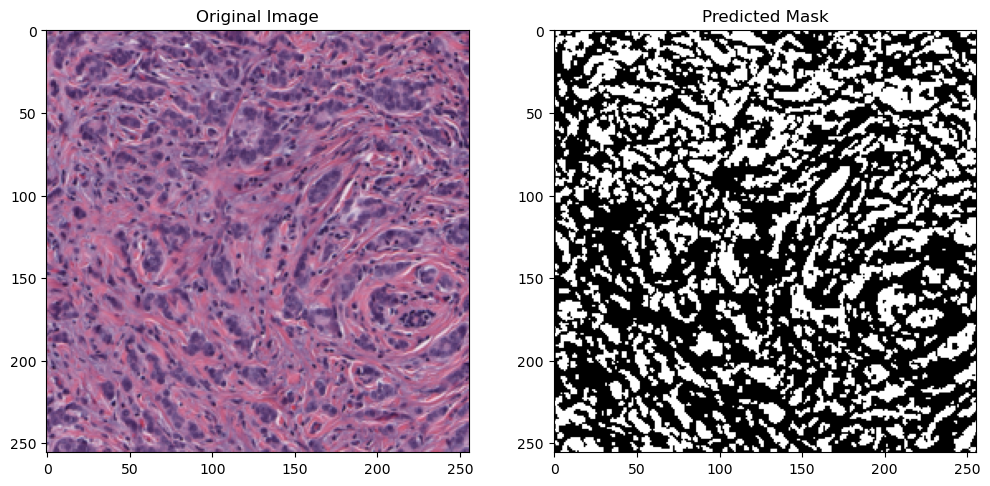

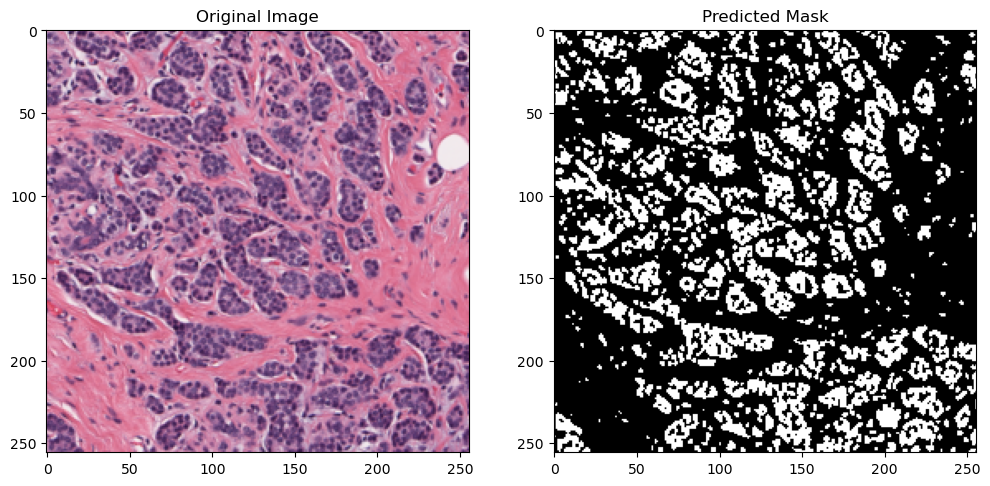

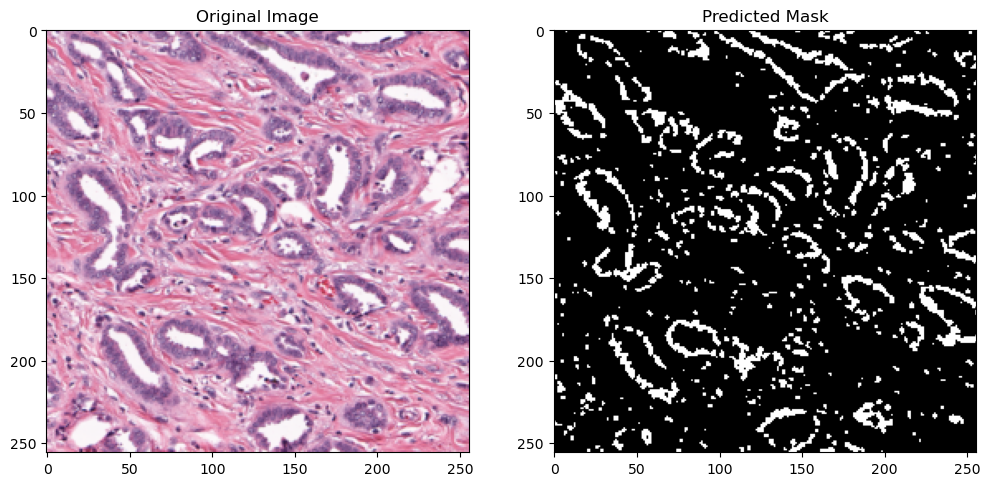

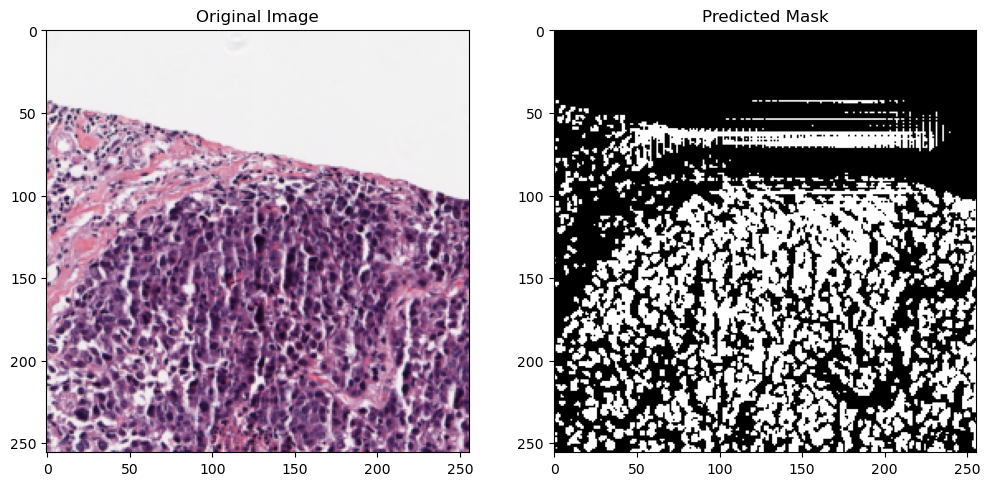

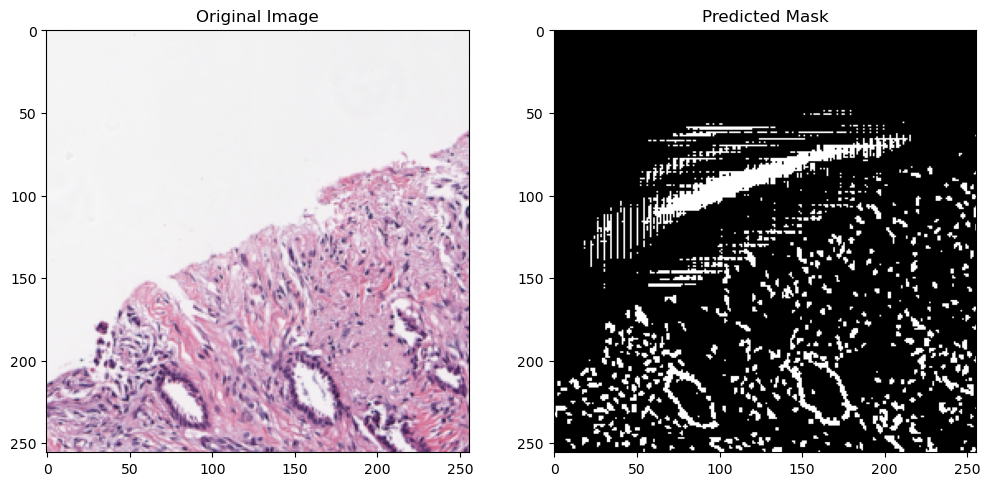

In [28]:
def display_sample_images(images, predicted_masks, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(images[i].permute(1, 2, 0))

        plt.subplot(1, 2, 2)
        plt.title('Predicted Mask')
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')

        plt.show()

# Get sample images
sample_images, _ = next(iter(test_loader))
sample_images = sample_images.cpu()

# Display sample predictions
display_sample_images(sample_images, predicted_masks, num_samples=5)

Inference: 

•	Defined the model and metrics for evaluation of the model. Trained it over 25 epochs. Got an improved test accuracy of 78%, and loss is also minimized. 
